In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)

In [4]:
y.head()

,0
Date,
2005-08-24,3.12857
2005-08-25,3.23000
2005-08-26,3.23714
2005-08-27,3.24429
2005-08-28,3.25143


In [5]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 500]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]


# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3618, 500)  train1 y: (3618, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
validation1 X: (400, 500)  validation1 y: (400, 1)
train2 X: (3293, 500)  train2 y: (3293, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)
validation2 X: (360, 500)  validation2 y: (360, 1)


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


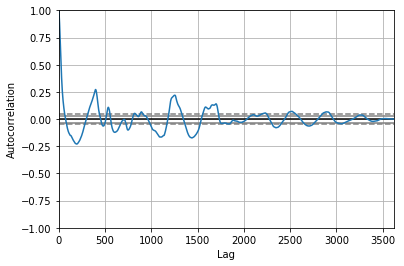

In [6]:
# no clear trend from the graph above, need to try d of different values.
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(train1_y)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


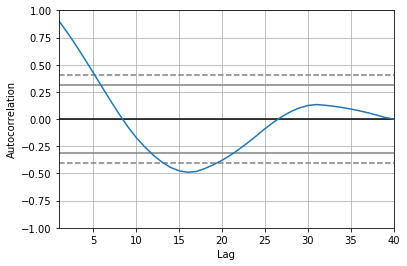

In [7]:
autocorrelation_plot(train1_y[:40])

In [8]:
# the above plot shows the possible significant AR term may be 5
# anyway, just tune the possible choices
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(train1_y2.values, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4017
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2390.608
Method:                       css-mle   S.D. of innovations              0.439
Date:                Wed, 05 Sep 2018   AIC                           4795.216
Time:                        04:26:44   BIC                           4839.304
Sample:                             1   HQIC                          4810.841
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.052     -0.007      0.994      -0.103       0.102
ar.L1.D.y      0.9336      0.016     59.317      0.000       0.903       0.964
ar.L2.D.y    5.48e-05      0.022      0.003      0.9

In [9]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)

def evaluate_arima_model1(dataset, p,d,q):
    # fit model
    model = ARIMA(dataset.values, order=(p,d,q))
    model_fit = model.fit(disp=0)
  
    y_pred1=[]
    for t in range(test1_y.shape[0]):
        yhat = model_fit.forecast()[0][0]
        y_pred1.append(yhat)
    error = sqrt(mean_squared_error(val1_y, y_pred1))
    return error

In [10]:
## tune the parameters by rmse
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score=100000
    p0=-1
    d0=-1
    q0=-1
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    rmse = evaluate_arima_model1(dataset, p,d,q)
                    if rmse < best_score:
                        best_score = rmse
                        p0=p
                        d0=d
                        q0=q
                    print(p,',',d,',',q,' RMSE:',rmse)
                except:
                    continue
    print('Best ARIMA (',p0,',',d0,',',q0,') RMSE:',best_score)


In [ ]:
p_values = [1,3,7,9]
d_values = range(0, 3)
q_values = range(0, 5)
evaluate_models(train1_y, p_values, d_values, q_values)

1 , 0 , 0  RMSE: 10.03384360922473
1 , 0 , 1  RMSE: 10.05200638344834
1 , 0 , 2  RMSE: 10.088880341847268
1 , 0 , 3  RMSE: 10.065493202593318
1 , 0 , 4  RMSE: 10.075986514377025
1 , 1 , 0  RMSE: 10.105110229999624
1 , 1 , 1  RMSE: 10.104803621656574
1 , 1 , 2  RMSE: 10.104324970808438
1 , 1 , 3  RMSE: 10.103611111311357
1 , 1 , 4  RMSE: 10.110223235098854
1 , 2 , 0  RMSE: 10.11182966066178


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 1  RMSE: 10.111829660444279


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 2  RMSE: 10.111829658982405


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 3  RMSE: 10.111829660339806


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 4  RMSE: 10.111830378899747
3 , 0 , 0  RMSE: 10.077030084122118


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 , 0 , 1  RMSE: 10.083081066901084


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 , 0 , 2  RMSE: 10.083405591319217
3 , 0 , 3  RMSE: 10.084300644926271
3 , 0 , 4  RMSE: 10.08726049100803
3 , 1 , 0  RMSE: 10.104334545614117
3 , 1 , 1  RMSE: 10.081278313807985
3 , 1 , 2  RMSE: 10.079547806156079
3 , 1 , 3  RMSE: 10.080352481541674
3 , 1 , 4  RMSE: 10.111361954649398
3 , 2 , 0  RMSE: 10.111829661705015


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


3 , 2 , 1  RMSE: 10.111829664653778


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


3 , 2 , 2  RMSE: 10.111829659600094


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


3 , 2 , 3  RMSE: 10.111829657897443
3 , 2 , 4  RMSE: 10.1227878684446


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7 , 0 , 1  RMSE: 10.085547712443407
7 , 0 , 2  RMSE: 10.072477985211458
7 , 0 , 3  RMSE: 10.09379862202782


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodel

7 , 1 , 0  RMSE: 10.109598295879907
7 , 1 , 1  RMSE: 10.109607578603145
7 , 1 , 2  RMSE: 10.108952337344935
7 , 1 , 3  RMSE: 10.106724616648997


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


7 , 1 , 4  RMSE: 10.12089696408284
7 , 2 , 0  RMSE: 10.111828856327202
7 , 2 , 1  RMSE: 10.111828856125836
7 , 2 , 2  RMSE: 10.11182885609232
7 , 2 , 3  RMSE: 10.111828858004095


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


7 , 2 , 4  RMSE: 10.107753173363841
9 , 0 , 1  RMSE: 10.083658233268775


In [15]:
## by validation set and RMSE we get (1,0,0), check this model, quite poor AIC
model = ARIMA(train1_y2.values, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4018
Model:                     ARMA(1, 0)   Log Likelihood               -5670.578
Method:                       css-mle   S.D. of innovations              0.992
Date:                Thu, 12 Jul 2018   AIC                          11347.155
Time:                        15:19:08   BIC                          11366.051
Sample:                             0   HQIC                         11353.852
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2530      4.696      1.757      0.079      -0.952      17.458
ar.L1.y        0.9969      0.001    855.820      0.000       0.995       0.999
                                    Roots           

In [11]:
## now model selection via AIC
def evaluate_arima_model2(dataset, p,d,q):
    # fit model
    model = ARIMA(dataset.values, order=(p,d,q))
    model_fit = model.fit(disp=0)
  
    error = model_fit.aic
    return error


## tune the parameters by rmse
def evaluate_models2(dataset, p_values, d_values, q_values):
    best_score=1000000000
    p0=-1
    d0=-1
    q0=-1
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    aic = evaluate_arima_model2(dataset, p,d,q)
                    if aic < best_score:
                        best_score = aic
                        p0=p
                        d0=d
                        q0=q
                    print(p,',',d,',',q,' AIC:',aic)
                except:
                    continue
    print('Best ARIMA (',p0,',',d0,',',q0,') AIC:',best_score)


In [ ]:
p_values = [0]
d_values = [0,2]
q_values = [13,14,15]
evaluate_models2(train1_y2, p_values, d_values, q_values)

In [13]:
p_values = [1]
d_values = [0,2]
q_values = [13,14,15]
evaluate_models2(train1_y2, p_values, d_values, q_values)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 0 , 13  AIC: 3040.6277190449655


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 0 , 14  AIC: 3041.3478579625425


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 0 , 15  AIC: 3041.972256208728


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 14  AIC: 3107.04911893767
1 , 2 , 15  AIC: 3109.0491149891986
Best ARIMA ( 1 , 0 , 13 ) AIC: 3040.6277190449655


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [17]:
p_values = [1]
d_values = [0,1]
q_values = [12,14]
evaluate_models2(train1_y2, p_values, d_values, q_values)

1 , 0 , 12  AIC: 3559.695741732131


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 0 , 14  AIC: 3041.3478579625425


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 1 , 12  AIC: 3476.675938444322
1 , 1 , 14  AIC: 3039.6810607036296
Best ARIMA ( 1 , 1 , 14 ) AIC: 3039.6810607036296


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [19]:
p_values = [1]
d_values = [1]
q_values = [15]
evaluate_models2(train1_y2, p_values, d_values, q_values)

1 , 1 , 15  AIC: 3040.4316560984407
Best ARIMA ( 1 , 1 , 15 ) AIC: 3040.4316560984407


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [9]:
## now by rmse we otbtain(1,0,0), by aic we have (11,0,4) compare the performance of the two 
## on all training set including validation, and compare reuslts on test set
#model1 = ARIMA(train1_y2.values, order=(1,0,0))
#model_fit1 = model1.fit(disp=0)
#print(model_fit1.summary())

#model2 = ARIMA(train1_y2.values, order=(1,1,14))
#model_fit2 = model2.fit(disp=0)
#print(model_fit2.summary())

from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)



In [15]:
train1 = train1_y2.values

test1 = test1_y.values

history = [x for x in train1]
predict = list()

model = ARIMA(history, order=(1,1,14))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=365)[0]
output

predict=output

mae1 = mean_absolute_error(test1_y, output)
rmse1 = sqrt(mean_squared_error(test1_y, output))
print(mae1,rmse1)

4.348800057881112 5.395002499840843


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [10]:
train1 = train1_y2.values
test1 = test1_y.values

history = [x for x in train1]
predict = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast()
    yhat = output[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)
    history = history[1:]

mae1 = mean_absolute_error(test1_y, predict)
rmse1 = sqrt(mean_squared_error(test1_y, predict))

print(mae1,rmse1)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1.1791194341053672
1.1175311325964712
1.1021498092800375
1.1810665091227575
1.2174504983069363
1.2521329562370902
1.2849547878846972
1.3215618875729118
1.3556930682846842
1.3737656739252975
1.5134947025942214
1.5968471849456776
1.6786923237573057
1.7586357984899064
1.8422539264221025
1.9235662691648874
1.9476741006216838
1.9574111171287107
1.9778394349088562
1.9966057175314182
2.013753490988441
2.03499465621363
2.0526352884223615
2.047710862674293
2.4306844395302467
2.6257283428835057
2.8189713142069794
3.0108213663068604
3.2050438976587032
3.3989281913650222
3.480445960578408
3.9056548517880243
4.165653643883991
4.4244182200769515
4.6820894184036845
4.942643824089718
5.200535091065711
5.274449977177461
5.868057443689935
6.207662531965446
6.546730535935478
6.884598473580181
7.224142714635894
7.563012800775085
7.675173803236191
7.587740024227307
7.600530885867034
7.613377289487828
7.6250738416030694
7.641256568730097
7.650071364992203
7.609048265714253
7.40765971032204
7.283635303429166

In [11]:
test1[1],predict[1]

(array([1.09]), 1.1175311325964712)

In [12]:
corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr3 = np.corrcoef(corr_y['y_act'],predict)[0,1]
corr3

0.9998116129899499

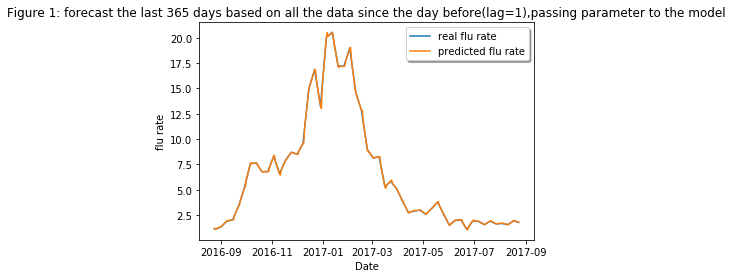

In [13]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 1: forecast the last 365 days based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [44]:
model_fit = model.filter(training_res.params)
output = model_fit.forecast(steps=5)
yhat = output[4]
print(yhat)

1.4342299536626504


In [10]:
train1 = train1_y2.values[:4018-4]
test = y.values[4018-4:]
test1 = test1_y.values


history = [x for x in train1]
predict2 = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=5)
    yhat = output[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1.5171350329626112
1
1.4609639196756217
2
1.4452974305718667
3
1.428544194063432
4
1.4169646950157202
5
1.401060534156684
6
1.3831977741342394
7
1.6354032054594896
8
1.6751293062179673
9
1.6937597363198904
10
1.7105430509819637
11
1.7321261067313083
12
1.7490950246514463
13
1.765099826305656
14
2.1292828415881844
15
2.2148471985489455
16
2.2386414815907574
17
2.261195956710927
18
2.2889060021488024
19
2.312169399243057
20
2.333601064712437
21
2.312777952891802
22
2.3366570174741232
23
2.333920239173138
24
2.3295852562209487
25
2.3291862441840605
26
2.322862606622299
27
2.317447186744014
28
3.424186897214489
29
3.6197973862407204
30
3.6958603698271277
31
3.771898512088783
32
3.8549377908960447
33
3.936329602788539
34
4.010478807082825
35
5.063924213327893
36
5.325722192592048
37
5.398484751084177
38
5.46942927322998
39
5.545519939326855
40
5.617041121827492
41
5.689059324716086
42
7.246512995787269
43
7.584463331544403
44
7.690413604771123
45
7.795493668446713
46
7.907723987331547
47
8.

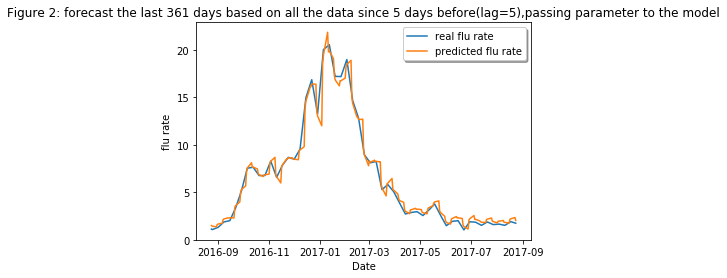

In [11]:

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 2: forecast the last 361 days based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [12]:
## lag=10
train1 = train1_y2.values[:4018-9]
test = y.values[4018-9:]
test1 = test1_y.values

history = [x for x in train1]
predict3 = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=10)
    yhat = output[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict3
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2.4521890587011588
1
2.429077789581675
2
2.437678722529232
3
2.432214745441858
4
2.4411371759111544
5
2.2276253516311675
6
2.2111179370008034
7
2.1938904907257957
8
2.1752758674460058
9
2.175067150680763
10
2.1692163120286567
11
2.169230485793646
12
2.518264739192127
13
2.536017608974036
14
2.553098784227021
15
2.567291698042485
16
2.5669055068330757
17
2.560850655484481
18
2.5608868063119323
19
3.0121149391193267
20
3.034511254816108
21
3.0560687284252235
22
3.0755950585877785
23
3.0751411164335747
24
3.069701014478405
25
3.0693651923228833
26
3.0062607574579197
27
3.0058713177202954
28
3.0056038809219032
29
3.001805122161489
30
3.0050504202786237
31
2.999850861329749
32
3.0033022105692506
33
4.462730792142091
34
4.529579229294162
35
4.593604433138078
36
4.659523432388468
37
4.651044729740706
38
4.644159510767922
39
4.637233485044765
40
5.915889389079898
41
5.983957478198157
42
6.052809379253421
43
6.118840653771429
44
6.117448480782485
45
6.111179328515073
46
6.111849435765009
47
8.0

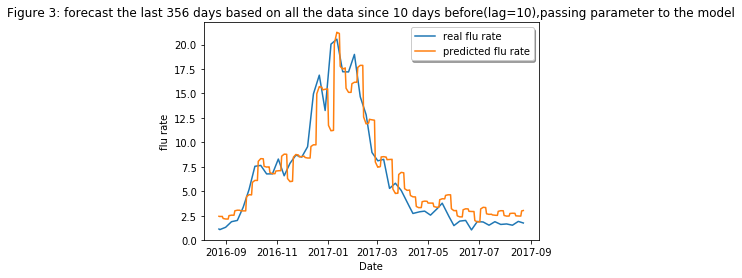

In [13]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 3: forecast the last 356 days based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [14]:
## lag=14
train1 = train1_y2.values[:4018-13]
test = y.values[4018-13:]
test1 = test1_y.values

history = [x for x in train1]
predict4 = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=14)
    yhat = output[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict4
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3.7517120305304075
1
3.727475300106239
2
3.154869137592472
3
3.1753801770862533
4
3.1879374252936405
5
3.196724675198567
6
3.205369465108081
7
3.19904415513728
8
3.203249058075933
9
2.986730770440806
10
2.9957929989362455
11
2.9861365915735347
12
2.979164990257839
13
2.9787735434774887
14
2.9693715174715356
15
2.954944970634848
16
3.3201887858342736
17
3.3315578430635813
18
3.3237758204341565
19
3.3182572968402555
20
3.3180396275619586
21
3.3084360347246062
22
3.294563242827325
23
3.7664390455821195
24
3.776068878074992
25
3.766106943197911
26
3.7597411071007563
27
3.759181800194973
28
3.7493734550485325
29
3.7356596745685247
30
3.675741758553766
31
3.689141169206782
32
3.6878850614657255
33
3.687697028884648
34
3.6907473883970416
35
3.6822668851967286
36
3.6772047236325576
37
5.193791404319734
38
5.192354435641028
39
5.16630475145268
40
5.146715682616677
41
5.13853615458564
42
5.126411693917405
43
5.1020763882991025
44
6.429393304331015
45
6.432900695660822
46
6.423022476429922
47
6.4

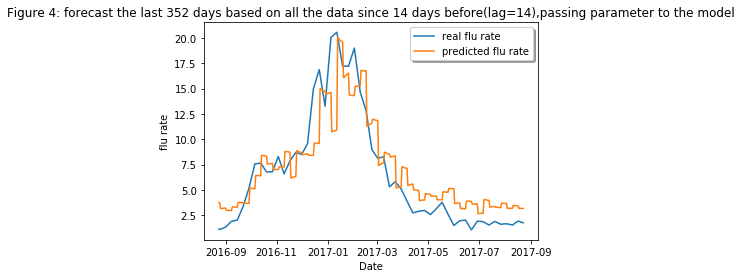

In [15]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 4: forecast the last 352 days based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [16]:
## lag=28
train1 = train1_y2.values[:4018-27]
test = y.values[4018-27:]
test1 = test1_y.values

history = [x for x in train1]
predict5 = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=28)
    yhat = output[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict5
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6.333823854126335
1
6.3167590011735495
2
5.712377656897259
3
5.730978339795767
4
5.745255261279288
5
5.765541687550961
6
5.771049096475848
7
5.777765408423054
8
5.781622331438156
9
5.9044144490515995
10
5.8915569339171086
11
5.879162382366131
12
5.870109173839155
13
5.848893375278429
14
5.837265082147668
15
5.825673096169321
16
5.511222312397192
17
5.519569386779629
18
5.524955093133379
19
5.535311622366978
20
5.530492914033279
21
5.530470981161235
22
5.527389026329418
23
5.402871204108965
24
5.398319074145567
25
5.3931374310612865
26
5.3921964776012965
27
5.376463371204563
28
5.369732818605009
29
5.36160511397548
30
5.5623211214149535
31
5.559399872658291
32
5.555521736353073
33
5.554878016869581
34
5.5398551080625165
35
5.5327752397332395
36
5.525549505151035
37
5.784891591768941
38
5.780492103227909
39
5.775293659739883
40
5.773541619445667
41
5.759380004920329
42
5.752160692271543
43
5.745155623466956
44
5.711449144612251
45
5.711741187141216
46
5.710362496069473
47
5.7131894907426

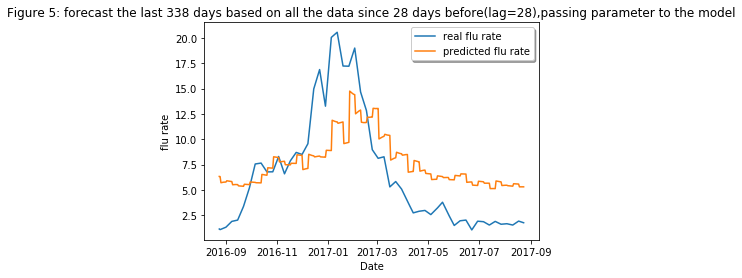

In [17]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict5,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 5: forecast the last 338 days based on all the data since 28 days before(lag=28),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

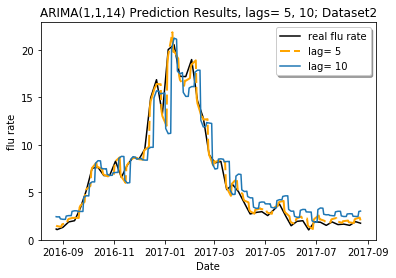

In [22]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate', color='black')
ax.plot(date[4018:],predict2,dashes=[5,2,20,2], linewidth=2,color='orange',label='lag= 5')
ax.plot(date[4018:],predict3,label='lag= 10')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("ARIMA(1,1,14) Prediction Results, lags= 5, 10; Dataset2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("arima510_test2.pdf", bbox_inches='tight')

plt.show()

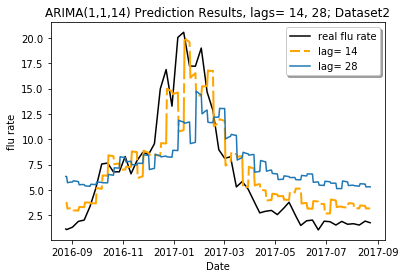

In [23]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate', color='black')
ax.plot(date[4018:],predict4,dashes=[5,2,20,2], linewidth=2,color='orange',label='lag= 14')
ax.plot(date[4018:],predict5,label='lag= 28')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("ARIMA(1,1,14) Prediction Results, lags= 14, 28; Dataset2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("arima1428_test2.pdf", bbox_inches='tight')

plt.show()

In [18]:
arimax_ex_t2 = pd.read_csv('ARIMAX_EN_t2.csv',header=None)

ValueError: x and y must have same first dimension, but have shapes (338,) and (365,)

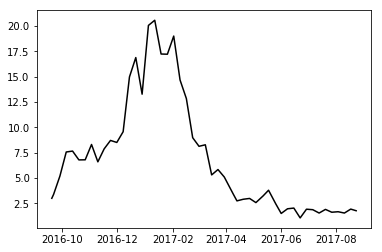

In [19]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate',color='black')
ax.plot(date[4018:],predict5,label='ARIMA(1,1,14)',dashes=[5,2,20,2], linewidth=2,color='orange')
ax.plot(date[4018:],arimax_ex_t2[1].values,label='ARIMAX_EN',dashes=[2,2], linewidth=2,color='green')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("lag= 28, test set 2")
plt.ylabel('flu rate')
plt.xlabel('Date')
plt.savefig("ar_test2.pdf", bbox_inches='tight')
plt.show()

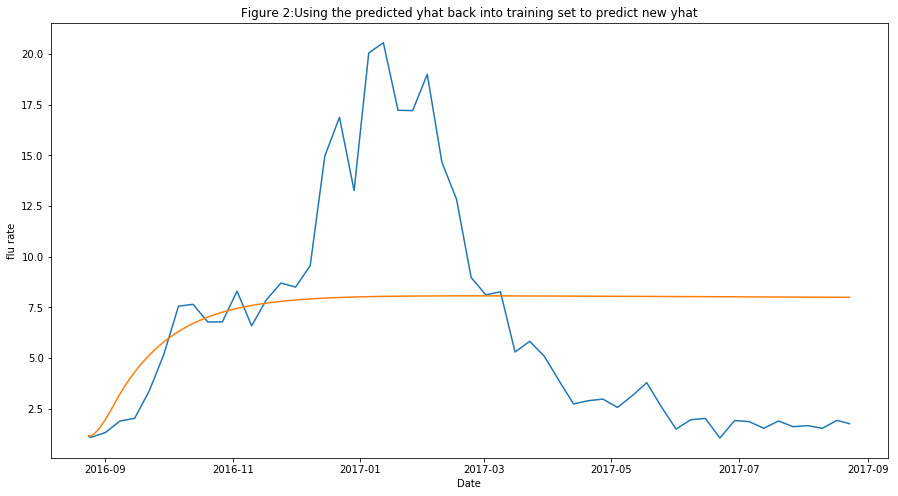

In [21]:
## results of above iteratively prediction 
predict2=   [1.17728183,1.1650975,1.22402906,1.30387754,1.40379864,1.52525009,1.66675996,1.81504843,1.96891683,2.14070386,2.31727531,2.49810602,2.68367832,2.87322547,3.05615562,3.23269185,3.40301013,3.56737837,
            3.72600493,3.87908551,4.02681623,4.16940779,4.30704519,4.43988732,4.56811368,4.69187792,4.81133435,4.92662897,5.0379172,5.14532646,5.24900171,5.34905634,5.44563163,5.53885598,5.62882835,5.71567021,
            5.79949884,5.88040801,5.95850058,6.03387403,6.10661813,6.17684649,6.24463225,6.3100625,6.37321128,6.43416407,6.49299116,6.54975336,6.60453004,6.65739214,6.70840892,6.75764423,6.80516038,6.85101357,
            6.89527966,6.93799121,6.9792067,7.01898596,7.05737272,7.09442454,7.13017917,7.16467587,7.19796026,7.23007614,7.26106567,7.29096745,7.31981179,7.3476421,7.37449125,7.40040076,7.42539772,7.4495079,
            7.47276511,7.49518339,7.51681312,7.53767761,7.5578018,7.57722755,7.59596212,7.61403245,7.63146546,7.64827677,7.66448926,7.68012224,7.69518653,7.70971149,7.7237178,7.73722875,7.75025443,7.76283067,
            7.77495961,7.78662756,7.79787676,7.8087204,7.81918005,7.82926522,7.83896993,7.84831432,7.85733191,7.86602693,7.87440643,7.88247713,7.89024994,7.89773286,7.90493879,7.91188794,7.91857762,7.92501754,
            7.93122102,7.93717911,7.94291686,7.94844357,7.95376268,7.95887924,7.9638022,7.96853585,7.97309665,7.97748366,7.98170495,7.98575358,7.98964585,7.99339632,7.99700377,8.0004757,8.00381079,8.00699767,
            8.0100586,8.01299588,8.01581013,8.01849895,8.02109358,8.02358343,8.02597851,8.02827295,8.03048132,8.0325937,8.03461359,8.03652895,8.03836697,8.04013177,8.04182591,8.04343626,8.04497332,8.04644759,
            8.0478535,8.04919091,8.05046732,8.05168372,8.05284112,8.0539425,8.05499303,8.05599525,8.05694324,8.05783346,8.05867908,8.05948112,8.06023969,8.06166986,8.06232502,8.06294728,8.06353482,8.06408609,
            8.06462251,8.06511224,8.06556895,8.06599272,8.06643102,8.0668379,8.06721485,8.0675512,8.06785085,8.06811622,8.06835766,8.06855108,8.06872075,8.06887012,8.06898941,8.06908777,8.06917064,8.06923464,
            8.06926215,8.06927613,8.06927207,8.0692519,8.06920781,8.06915344,8.06908439,8.06900123,8.0689029,8.06879012,8.06866637,8.06853597,8.06838647,8.06822614,8.06805557,8.0678727,8.06768174,8.06748026,
            8.06727055,8.06705528,8.06683198,8.06659646,8.066333,8.06606185,8.06578928,8.06551131,8.06523681,8.06495493,8.06465493,8.06436734,8.06407241,8.06376878,8.06346011,8.06314188,8.06282662,8.06251595,
            8.06220489,8.06188895,8.06156435,8.06123498,8.06089933,8.06055168,8.06020573,8.05985295,8.05950727,8.05915821,8.05880513,8.05844789,8.0580849,8.05771835,8.05734835,8.05696829,8.05658208,8.05619284,
            8.05579503,8.0553998,8.05500211,8.05459521,8.05418114,8.05376682,8.05335064,8.05292787,8.05250264,8.05207536,8.05165028,8.05122104,8.05079119,8.05036159,8.0499374,8.04950946,8.04908756,8.04866931,
            8.04824352,8.04824352,8.04781545,8.04738618,8.04695827,8.04652839,8.04609382,8.04565872,8.04522841,8.04479708,8.04436236,8.04392636,8.04348847,8.0430457,8.04260009,8.04215732,8.04171409,8.04126991,
            8.04082506,8.04036924,8.03991311,8.03945186,8.03899026,8.0385241,8.03805978,8.03759527,8.03713701,8.0366785,8.03622179,8.03576518,8.03531057,8.03485451,8.03439814,8.03394605,8.03349009,8.03303669,
            8.0325825,8.03212956,8.03167578,8.03118689,8.03069731,8.03021033,8.0297232,8.02923405,8.0287449,8.02828935,8.02785277,8.0274165,8.02698442,8.02655109,8.02611752,8.02567091,8.02520429,8.02475239,
            8.02430001,8.02384481,8.0233885,8.02293279,8.02248155,8.02201534,8.0215427,8.02106612,8.02058856,8.02011103,8.01964331,8.01918201,8.0187206,8.01823212,8.01774657,8.01726176,8.01679237,8.01630756,
            8.01582411,8.01533957,8.01487555,8.0144132,8.01395223,8.01348291,8.01301586,8.01255409,8.01209319,8.0116609,8.01122774,8.01079255,8.01035125,8.00991384,8.00947302,8.00903171,8.0085793,8.00812626,
            8.00767213,8.00721728,8.0067619,8.0063033,8.00587837,8.0054439,8.00501734,8.0045906,8.00416213,8.00370799,8.00325371,8.0027795,8.00230673,8.00183548,8.00136777,8.00088527,8.00041694,7.99995121,
            7.9994701,7.99899079,7.9985036,7.9980142,7.99753405]
mae2 = mean_absolute_error(test1_y, predict2)
rmse2 = sqrt(mean_squared_error(test1_y, predict2))

print(mae2,rmse2)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],date[4018:],predict2)
plt.title("Figure 2:Using the predicted yhat back into training set to predict new yhat")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()